# Table detection with Faster R-CNN
Dataset: https://github.com/sgrpanchal31/table-detection-dataset

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops.boxes import nms
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import time

In [1]:
path = 'table-detection-dataset/'

In [5]:
df_train = pd.read_csv(path+'train.csv', names=['filename', 'xmin', 'ymin', 'xmax' , 'ymax', 'class'])
df_val = pd.read_csv(path+'val.csv', names=['filename', 'xmin', 'ymin', 'xmax' , 'ymax', 'class'])
df_train["filename"].nunique(), df_val["filename"].nunique()

(338, 65)

In [6]:
df_train.head()

,filename,xmin,ymin,xmax,ymax,class
0,0101_003.png,770,946,2070,2973,table
1,0110_099.png,270,1653,2280,2580,table
2,0113_013.png,303,343,2273,2953,table
3,0140_007.png,664,1782,1814,2076,table
4,0146_281.png,704,432,1744,1552,table


In [7]:
df_train['bbox'] = df_train[['xmin', 'ymin', 'xmax' , 'ymax']].apply(list, axis=1)
df_val['bbox'] = df_val[['xmin', 'ymin', 'xmax' , 'ymax']].apply(list, axis=1)

df_train['class'] = df_train['class'].map({'table': 1})
df_val['class'] = df_val['class'].map({'table': 1})

df_train = df_train.drop(columns=['xmin', 'ymin', 'xmax' , 'ymax']).groupby('filename', as_index=False).agg(list)
df_val = df_val.drop(columns=['xmin', 'ymin', 'xmax' , 'ymax']).groupby('filename', as_index=False).agg(list)

In [8]:
df_train.head()

,filename,class,bbox
0,0101_003.png,[1],"[[770, 946, 2070, 2973]]"
1,0110_099.png,[1],"[[270, 1653, 2280, 2580]]"
2,0113_013.png,[1],"[[303, 343, 2273, 2953]]"
3,0140_007.png,[1],"[[664, 1782, 1814, 2076]]"
4,0146_281.png,"[1, 1]","[[704, 432, 1744, 1552], [682, 1740, 1800, 2440]]"


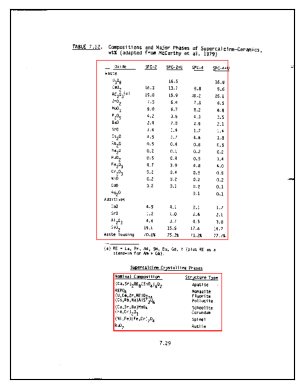

In [14]:
def draw_img_with_box(df_index, scale_percent=20):
    path_to_img = os.path.join(path + 'images', df_train.loc[df_index, 'filename'])
    img = cv2.imread(path_to_img)
    boxes =  df_train.loc[df_index, 'bbox']
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

draw_img_with_box(100)

In [ ]:
class MyDataset(Dataset):  
    def __init__(self, dataframe, img_path):
        
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [24]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/table-detection-dataset/images')
val_dataset = MyDataset(df_val, '/content/table-detection-dataset/images')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

In [28]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

In [29]:
def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Epoch #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"{round((end - start) / 60, 1)} minutes for {epoch} epoch")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=25):
    model.eval()
    img = cv2.imread(os.path.join('/content/table-detection-dataset/images', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img, 
                    (int(box[0]), int(box[1])), 
                    (int(box[2]), int(box[3])), 
                    (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
draw_predict(63, 0.1)